<a href="https://colab.research.google.com/github/TamaraMaggioni/DiploDatos2021/blob/main/AnalisisYVisualizacion/Entregable_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---

# Trabajo práctico entregable - Parte 2

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy 
import pandas as pd
import seaborn
import scipy
from scipy.stats import norm

seaborn.set_context('talk')

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [ ]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.0,Bruto,Full-Time,53000.0,43000.0,NaN,1,1,No,No recibo bono,No,0.0,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.0,Bruto,Full-Time,79000.0,63000.0,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.0,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.0,Porcentaje de mi sueldo,Full-Time,160000.0,127000.0,NaN,3,3,Un sueldo,Performance individual,No,0.0,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


In [ ]:
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                ...                     
                             count          mean  ...       75%        max
profile_gender                                    ...                     
Hombre                      4944.0  98836.063558  ...  110000.0  2080000.0
Mujer                        908.0  73501.414465  ...   92000.0   800000.0
Otros                         31.0  95441.354839  ...  117500.0   380000.0

[3 rows x 8 columns]

In [ ]:
df[df.salary_monthly_NETO > 1000]\
  [['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                 ...                     
                             count           mean  ...       75%        max
profile_gender                                     ...                     
Hombre                      4815.0  101481.624343  ...  110000.0  2080000.0
Mujer                        863.0   77328.913778  ...   93000.0   800000.0
Otros                         28.0  105660.714286  ...  122750.0   380000.0

[3 rows x 8 columns]

In [ ]:
alpha = 0.05

In [ ]:
is_man = df.profile_gender == 'Hombre'

groupA = df[(df.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
groupB = df[(df.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

In [ ]:
# Calculamos la estimacion puntual para la diferencia de medias:
mean_difference = groupA.mean() - groupB.mean()
print('diferencia_medias:', mean_difference)

diferencia_medias: 23262.37339991823


Podemos calcular el intervalo de confianza (IC) de forma manual, reemplazando los valores en las formulitas de grados de libertad y de diferencia de medias. Pero también podemos calcularlo mediante diferentes paquetes o librerías estadísticas (scipy.stats, en el caso de Python) y así evitar el uso de las tablas! Como haremos un test de dos colas, calcularemos dos valores, uno por cada extremos del IC. El límite superior estará dado por un valor de 0.975 (1 - alfa/2), mientras que el límite inferior estará dado por un valor de 0.025 (alfa/2). Esto, teniendo en cuenta que decidimos construir un IC con un alfa (total) de 0.05.


Se calculan los grados de libertad:

In [ ]:
m = len(groupA)
n = len(groupB)
es1 = groupA.std() / m**0.5
es2 = groupB.std() / n**0.5
v = (es1**2 + es2**2)**2 / (es1**4/(m-1) + es2**4/(n-1))
v = numpy.floor(v)
v

2148.0

Con los grados de libertad, podemos calculos los estadísticos t para las dos colas: t<sub>$\alpha$/2, $\nu$</sub> y t<sub>(1-$\alpha$/2), $\nu$</sub>

In [ ]:
scipy.stats.t.ppf(0.025,df=v), scipy.stats.t.ppf(0.975,df=v)

(-1.9610690058607223, 1.9610690058607219)

Esto nos permite definir el intervalo de confianza, con sus cotas inferior y superior

In [ ]:
IC_inferior = mean_difference + scipy.stats.t.ppf(0.025,df=v) * (groupA.std()**2/m + groupB.std()**2/n)**0.5
IC_superior = mean_difference + scipy.stats.t.ppf(0.975,df=v) * (groupA.std()**2/m + groupB.std()**2/n)**0.5
print('IC:', IC_inferior, ',', IC_superior)

IC: 18558.01633164585 , 27966.73046819061


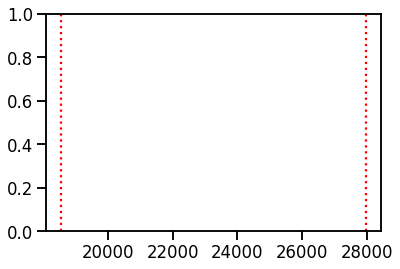

In [ ]:
_ = plt.axvline(IC_inferior, color='r', linestyle=':')
_ = plt.axvline(IC_superior, color='r', linestyle=':')

La prueba o test de hipótesis me permite tomar una decisión sobre un fenómeno conociendo la probabilidad de que esa decisión sea equivocada. El test de hipótesis no me va a dar verdades absolutas, sino grados de certeza. Así, la hipótesis nula, si no se encuentra evidencia suficiente para rechazarla, es cierta con un porcentaje de probabilidad de que sea incorrecta. 
Hay un criterio que juega de regla de decisión: el alfa. Este alfa no es más que el máximo error posible que estoy dispuesto a aceptar, o el máximo error aceptable en mi toma de decisión. Y es, precisamente, el valor con el que armo mi intervalo de confianza.  

## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

$H_0: \mu_{A} - \mu_{B} = 0$

**Estadístico (Pivote)**
  * Identificar el estadístico: Media muestral 
  * Escribir qué distribución tiene bajo $H_0$: $N(\mu_{A} - \mu_{B}, \sigma_{A}^2 + \sigma_{B}^2)$


### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.
3. Los dos grupos de nuestra muestra tienen tamaños muy distintos. ¿Esto afecta al tests?

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

Previo a seleccionar el test de hipótesis que voy a emplear en mis datos, necesito conocer: cómo se distribuyen y cuál es su varianza o dispersión.
No es necesario que mis datos presenten una distribución normal, sino "aproximadamente" normal. Esto se debe a que lo que me interesa realmente es que la población tenga una distribución normal. Y por el teorema central del límite, a medida que aumenta el n muestral, las distribuciones tienden a hacerse normales.  
Hay dos maneras de averiguar si mis datos presentan normalidad en su distribución: de forma gráfica y de forma numérica.
Una de esas formas gráficas implica el uso de un histograma que muestra la distribución de mis datos muestrales y se los contrasta con una línea teórica que indica la distribución que deberían tener mis datos si fueran normales.

(0.0, 500000.0)

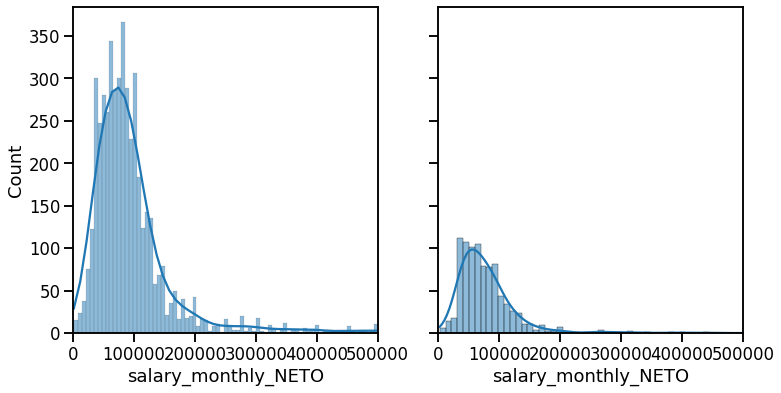

In [ ]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,6))
seaborn.histplot(groupA, ax=axes[0], kde=True)
seaborn.histplot(groupB, ax=axes[1], kde=True)
axes[0].set_xlim([0,500000])
axes[1].set_xlim([0,500000])

En ambos casos, vemos que la distribución real y teórica coinciden, por lo que nuestros datos presentan distribución aproximadamente normal.

También podemos utilizar métodos numéricos, que usan tests de hipótesis. Uno de los más usados es el test Shapiro-Wilkes. Cuando lo aplico a mis datos, este test me indica que es muy poco probable que los datos tengan una distribución normal (p = 0.0 para el grupoA y p = 7.5e-40 para el grupoB). Sin embargo, los resultados de este test están asociados al tamaño muestral. Cuando nuestros n ascienden a valores  mayores a 50, el test Shapiro empieza a no detectar normalidad. En estos casos, la mejor opción es recurrir a recurrir a las visualizaciones. 

In [ ]:
shapiro_test = stats.shapiro(groupA)
shapiro_test

NameError: ignored

In [ ]:
shapiro_test = stats.shapiro(groupB)
shapiro_test

Lo siguiente que debo realizar, es evaluar la variabilidad de los datos para determinar si las varianzas son homogéneas o heterogéneas. Esto se conoce también como homocedasticidad. De esto va a depender el test que vayamos a seleccionar.


In [ ]:
groupA.std(), groupB.std()

Acá podemos ver que los desvíos de ambos grupos son diferentes, pero para determinar cuán diferentes son (y si son o no homogéneos), empleamos otros tests numéricos que también utilizan tests de hipótesis. Uno de los más recomendados y más frecuentemente utilizados es el test de Levene, que basa sus cálculos en la mediana.

In [ ]:
levene_test = stats.levene(groupA, groupB, center='median')
levene_test


El test de Levene nos arroja un valor p bastante pequeño (p = 1.33e-6). Es decir, es muy poco probable de que nuestros datos sean homogéneos. Entonces, no podemos usar el test T (ya que asume homogeneidad de varianzas), sino el test de WELCH (o test T con correción de WELCH), que es un test no parametrico. Es quiere decir que no asume distribuciones determinadas de nuestros datos, sino que presupone distribuciones libres. Este test también nos sirve cuando los tamaños muestrales son tambien diferentes, como en nuestro caso. 

In [ ]:
stats.ttest_ind(groupA, groupB, equal_var = False)

El valor p es bastante mas chico que nuestro valor alfa (p = 8.6e-22: la probabilidad de que las medias de salarios sean iguales es muy baja), por lo que existe evidencia suficiente para afirmar que las medias de los salarios de los grupos contrastados son diferentes. En otras palabras, los varones cobran mas que los no-varones.

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)


In [ ]:
nobs1 = tt_ind_solve_power(effect_size=effect_size, nobs1=None, alpha=alpha, power=0.8, ratio=ratio)
nobs1

In [ ]:
nobs2 = nobs1 * ratio
nobs2

In [ ]:
nobs1 = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=0.9, ratio=ratio)
nobs1

In [ ]:
nobs2 = nobs1 * ratio
nobs2

In [ ]:
nobs1 = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=0.95, ratio=ratio)
nobs1

In [ ]:
nobs2 = nobs1 * ratio
nobs2

El poder estadistico de un test indica la probabilidad de cometer un error de tipo 2, o de aceptar la hipotesis nula cuando en realidad es falsa. Es decir, que la hipotesis alternativa es cierta sigo sin encontrar evidencias suficientes para rechazarla.
El poder es la probabilidad que tiene mi test de rechazar correctamente la hipotesis nula cuando es efectivametne falsa (y la correcta es la alternativa).

In [ ]:
groupA.count(), groupB.count()

Nuestras muestras superan ampliamente los tamaños necesarios en los tres niveles de beta probados, con un nivel de significancia de 0.05.

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
